In [1]:
import os
import cv2
import csv
import glob
import json
import pprint

import math
import numpy as np
import pandas as pd

import scipy
import matplotlib.pyplot as plt

In [2]:
#FRAME NUMBER, NUMBER OF HITS, HIT INTENSITY, TUG, RING DROP, JERK, MOTiON SMOOTHNESS 

In [3]:
df = pd.read_csv('./data/expert_scores_trainee_scores.csv')

In [4]:
df

,Video,Hand-eye Coordination,Instrument-Tissue Manipulation,Dexterity,Flow of procedure,Effectualness,Overall
0,E1_t1,3,3,3,3,4,15
1,E1_t2,3,3,3,2,1,8
2,E1_t3,4,3,4,4,4,18
3,E1_t4,3,2,4,4,4,16
4,E1_t5,3,3,4,4,4,17
5,E1_t6,3,3,4,4,4,17
6,E1_t7,4,4,4,4,4,20
7,E1_t8,3,3,4,4,4,17
8,E1_t9,4,4,4,4,4,20
9,E1_t10,4,3,4,4,4,19


In [5]:
df.columns

Index(['Video', 'Hand-eye Coordination', 'Instrument-Tissue Manipulation',
       'Dexterity', 'Flow of procedure', 'Effectualness', 'Overall'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ae2c92a58>,
      dtype=object)

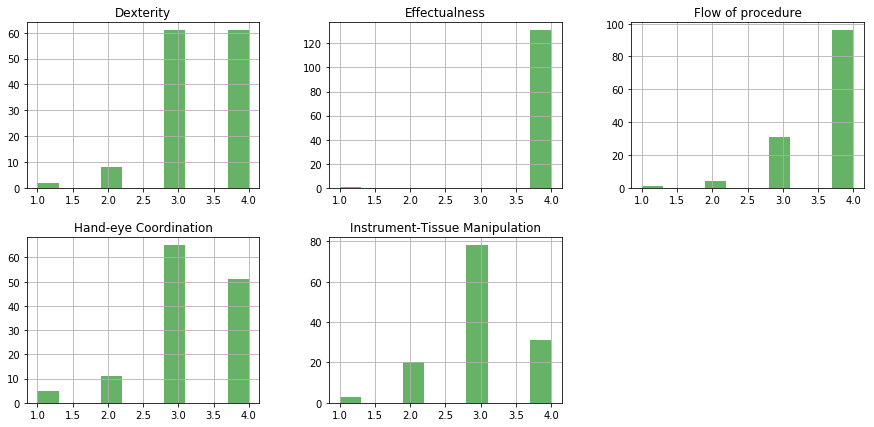

In [6]:
# Evaluation Metrics histogram
df.hist(color='g', column=['Hand-eye Coordination', 'Instrument-Tissue Manipulation',
       'Dexterity', 'Flow of procedure', 'Effectualness'], alpha=0.6, bins=10, layout=(2,3), figsize=(15,7))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ae0892cc0>]],
      dtype=object)

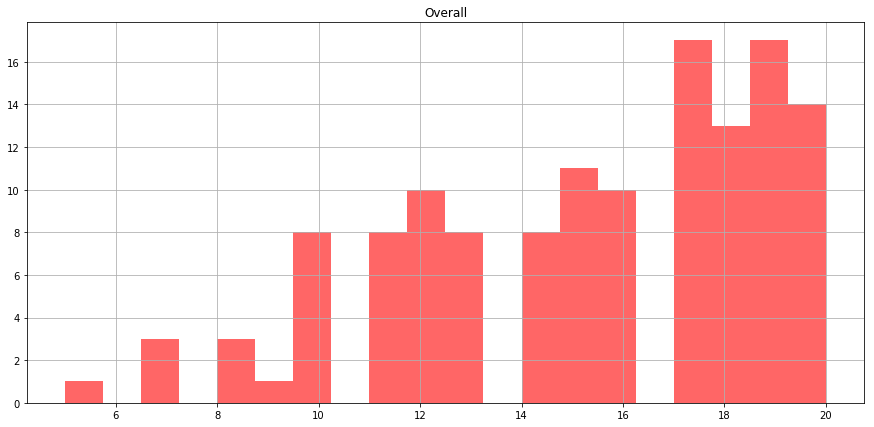

In [7]:
# Overall Score Histogram
df.hist(color='r', column=['Overall'], alpha=0.6, bins=20, figsize=(15,7))

In [8]:
HEC = df["Hand-eye Coordination"].tolist() 
ITM = df["Instrument-Tissue Manipulation"].tolist() 
Dex = df["Dexterity"].tolist() 
FOP = df["Flow of procedure"].tolist() 
Eff = df["Effectualness"].tolist() 
ALL = df["Overall"].tolist() 

# Processing Hand Selected Features and Tracking Features

In [9]:
def process_input(input_file):
    next(input_file)
    high,low=0, 0;
    frame_number, hits, hit_intensity,tug_event, tug, ring_drop_event, jerk, motion_smoothness, time = 0,0,0,0,[],0,0,0,0;
    for row in input_file:
        frame_number = int(row["#"])
        hits = hits + int(row[" H"])
        
        if int(row[" H"]) and int(row[" HI"]):
            high = high+1
        elif int(row[" H"]) and not int(row[" HI"]):
            low = low+1
        
        tug.append(int(row[" T"]))
        
        ring_drop_event = ring_drop_event+int(row[" R"]) 
        jerk = jerk+int(row[" J"])
        
        if  int(row[" M"]) > motion_smoothness:
            motion_smoothness = int(row[" M"])
    
    tug.append(0) #end
    count=0; #000000111100000011000000111110000000
    f = 0
    total = 0
    
    for i in range(len(tug)):
        if tug[i]==1:
            count= count+1;

        if tug[i]==0 and count:
            total=total+count
            count = 0
            tug_event = tug_event +1

    if high > low:
        hit_intensity = 1
    else:
        hit_intensity = 0
    time = frame_number/25
    return(hits, hit_intensity,tug_event, total, jerk, time, ring_drop_event)
    

In [10]:
label_root = "/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/GT_indicator/Experts_GT"

In [11]:
feature_dict = {}
for lbl_file in sorted(os.listdir(label_root)):
    #print(lbl_file)
    ff = open(label_root+"/"+lbl_file)
    if "E" in lbl_file:
        EXPERIENCE = 10 #hyperparameter
    else:
        EXPERIENCE = 2
    input_file = csv.DictReader(ff) # Ordered Dictionary
    NUMBER_OF_HITS, HIT_INTENSITY, NUMBER_OF_TUG, TOTAL_FRAMES_IN_TUG, NUMBER_OF_JERK, TIME, NUMBER_OF_RINGDROP  = process_input(input_file)
    
    filename = lbl_file.split("_GT")[0]
    feature_dict[filename] = [NUMBER_OF_HITS, HIT_INTENSITY, NUMBER_OF_TUG, TOTAL_FRAMES_IN_TUG, NUMBER_OF_JERK, TIME, NUMBER_OF_RINGDROP]#, EXPERIENCE]
    
data_gt = pd.DataFrame(feature_dict) 
data_gt = data_gt.transpose()
data_gt.columns = ["NUMBER_OF_HITS", "HIT_INTENSITY", "NUMBER_OF_TUG", "TOTAL_FRAMES_IN_TUG", "NUMBER_OF_JERK", "TIME", "NUMBER_OF_RINGDROP"]#,"EXPERIENCE"]

In [12]:
data_gt

,NUMBER_OF_HITS,HIT_INTENSITY,NUMBER_OF_TUG,TOTAL_FRAMES_IN_TUG,NUMBER_OF_JERK,TIME,NUMBER_OF_RINGDROP
E1_t10,2.0,0.0,2.0,23.0,0.0,11.96,0.0
E1_t11,2.0,0.0,1.0,19.0,0.0,12.96,0.0
E1_t12,2.0,0.0,3.0,26.0,0.0,20.96,0.0
E1_t1,2.0,1.0,1.0,9.0,6.0,19.96,0.0
E1_t2,0.0,0.0,1.0,3.0,0.0,10.68,1.0
E1_t3,0.0,0.0,2.0,19.0,3.0,8.96,0.0
E1_t4,1.0,0.0,1.0,17.0,5.0,16.84,0.0
E1_t5,1.0,0.0,1.0,15.0,3.0,11.00,0.0
E1_t6,2.0,0.0,1.0,16.0,0.0,12.96,0.0
E1_t7,2.0,1.0,1.0,31.0,0.0,17.76,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ae09fb080>,
      dtype=object)

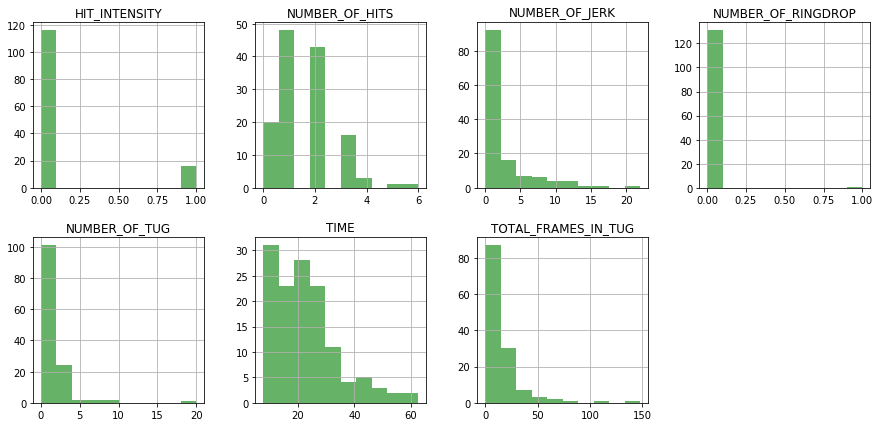

In [13]:
data_gt.hist(color='g', alpha=0.6, bins=10, layout=(2,4), figsize=(15,7))

In [14]:
feature_dict

{'E1_t10': [2, 0, 2, 23, 0, 11.96, 0],
 'E1_t11': [2, 0, 1, 19, 0, 12.96, 0],
 'E1_t12': [2, 0, 3, 26, 0, 20.96, 0],
 'E1_t1': [2, 1, 1, 9, 6, 19.96, 0],
 'E1_t2': [0, 0, 1, 3, 0, 10.68, 1],
 'E1_t3': [0, 0, 2, 19, 3, 8.96, 0],
 'E1_t4': [1, 0, 1, 17, 5, 16.84, 0],
 'E1_t5': [1, 0, 1, 15, 3, 11.0, 0],
 'E1_t6': [2, 0, 1, 16, 0, 12.96, 0],
 'E1_t7': [2, 1, 1, 31, 0, 17.76, 0],
 'E1_t8': [1, 0, 3, 12, 0, 12.92, 0],
 'E1_t9': [1, 0, 1, 18, 0, 7.64, 0],
 'E2_t10': [0, 0, 0, 0, 0, 9.56, 0],
 'E2_t11': [2, 0, 1, 8, 0, 20.84, 0],
 'E2_t12': [1, 1, 3, 26, 0, 27.52, 0],
 'E2_t1': [2, 0, 1, 5, 0, 20.0, 0],
 'E2_t2': [2, 0, 2, 42, 0, 19.84, 0],
 'E2_t3': [2, 0, 1, 23, 0, 11.68, 0],
 'E2_t4': [1, 0, 3, 18, 0, 17.68, 0],
 'E2_t5': [1, 0, 0, 0, 0, 11.84, 0],
 'E2_t6': [1, 0, 2, 37, 0, 17.84, 0],
 'E2_t7': [2, 0, 4, 76, 0, 26.88, 0],
 'E2_t8': [2, 0, 0, 0, 0, 16.0, 0],
 'E2_t9': [2, 0, 0, 0, 0, 19.68, 0],
 'E3_t10': [0, 0, 0, 0, 0, 8.76, 0],
 'E3_t11': [2, 0, 2, 24, 0, 15.64, 0],
 'E3_t12': [2, 0, 0,

In [15]:
## MIN MAX SCALLING
def normalize_min_max(a):
    return((a - np.min(a))/np.max(a))

def std_normalize(a):
    return((a - np.mean(a))/np.std(a))

def variance(a):
    return np.var(a)
    

In [16]:
def diff2D(indata) : # (fx+1 -fx)/ 1
    outdata=[]
    for i in range(len(indata)-1): # x_t+1 - x_t , y_t+1 - y_t
            outdata.append((indata[i + 1][0] - indata[i][0], indata[i + 1][1] - indata[i][1])); 
                           
    return outdata



In [17]:
#find curvature
def find_curvature(dx, ddx): #2d vector
    curvature = []
    for i in range(len(dx)-1):
        dd = pow(dx[i][0] * dx[i][0] + dx[i][1] * dx[i][1], 1.5)
        
        if(dd != 0) :
            curvature.append((abs((dx[i][0] * ddx[i][0]) - (dx[i][1] * ddx[i][1])))/ dd); 


    return curvature

In [18]:
#Arclength

def find_path_length(dx):#2d vector
    arc_length = 0
    
    for i in range(len(dx)):
        arc_length = arc_length+ pow((dx[i][0] * dx[i][0])+ (dx[i][1] * dx[i][1]), 0.5); 
        
    return arc_length;

In [19]:
def curvatureMaxnCount(curvature) :
    
    curvatureMax = 0; 
    curvatureMaxCount = 0; 
    
    if len(curvature) > 0:
        curvatureMax = curvature[0];

        for i in range(len(curvature)):

            if(abs(curvature[i]) > curvatureMax):
                curvatureMax = abs(curvature[i]); 

            if (abs(curvature[i]) > 300): #Hyperparameter : Define with respect to angle
                curvatureMaxCount = curvatureMaxCount+1; 

    return(curvatureMax, curvatureMaxCount)

In [20]:
def mean2D(data) : #2d np array input
    
    sumX, sumY = 0, 0;
    meanX, meanY = 0, 0;
    
    if(len(data)):
        for i in range(len(data)):
            sumX = sumX + data[i][0];
            sumY = sumY + data[i][1];

        meanX = sumX / len(data)
        meanY = sumY / len(data)
    
    return (meanX, meanY)

def max2D(data):
    
    maxX, maxY = 0, 0;
    
    if(len(data)):

        maxX = data[0][0];
        maxY = data[0][1];
        
        for i in range(len(data)):
            if (abs(data[i][0]) > maxX):
                maxX = abs(data[i][0]);
        
            if (abs(data[i][1]) > maxY):
                maxY = abs(data[i][1]);
    
    return  maxX, maxY

_
def var2D(indata): #2d np array

    meanX,meanY = 0, 0; 
    sumX, sumY = 0, 0; 
   
    sz = len(indata) - 1; 

    if( sz > 0):
        meanX, meanY = mean2D(indata); 
        
        for i in range(sz):

            sumX = sumX+ (indata[i][0] - meanX) * (indata[i][0] - meanX); 
            sumY = sumY+ (indata[i][1] - meanY) * (indata[i][1] - meanY); 


        sumX = sumX / sz; 

        sumY = sumY / sz; 
    
    return sumX, sumY


In [50]:
#find jerk
def find_jerk_vector(indata) : #2d vector
    jerk = []
    for i in range(len(indata)-3):
            jx = ((indata[i][0]) - (3 * indata[i + 1][0]) + (3 * indata[i + 2][0]) - (indata[i + 3][0]));
            jy = ((indata[i][1]) - (3 * indata[i + 1][1]) + (3 * indata[i + 2][1]) - (indata[i + 3][1]));
            ji = math.sqrt(jx*jx+ jy*jy)
            jerk.append(ji); 
            
    return jerk

In [51]:
def find_motion_smoothness(jerk): #1d vector
    j_tmp = 0
    for i in range(len(jerk)):
        j_tmp = j_tmp + (jerk[i]* jerk[i]); 
    motion_smoothness = math.sqrt (1/2 * j_tmp);
    return motion_smoothness

In [52]:
# motion_smoothness = find_motion_smoothness(jerk)

In [53]:
#                             M = cv2.moments(np.array(cnt, dtype = np.int32))
#                             cX = int(M["m10"] / M["m00"])
#                             cY = int(M["m01"] / M["m00"])

In [54]:
def find_right_corner(bbox):
    bbox = sorted(bbox,key=lambda x: x[1])[2:]
    
    if bbox[0][0] > bbox[1][0]:
        right_corner = bbox[0]
    else:
        right_corner = bbox[1]
    
    return right_corner[0], right_corner[1]

In [55]:
import sys 
#CENTROID BASED TRACKING
dir_root = "//home/kunaldargan/ROBO_SURGERY/MaskRCNNData/data_maskrcnn_clips/"
dirs= [ "E1", "E2", "E3", "E4", "E5", "E6", "T1_1", "T3_2", "T8_1","T9_1", "T10_2" ] #
data_tracking = {}
var_data = {}
var_data_x={}
var_data_y={}
arc_length_data ={}
curvature_data = {}
X_data = {}
Y_data = {}
X_Y_data = {}
motion_smoothness_data = {}


for d in dirs:
    directory = os.path.join(dir_root,d)

    for folder in sorted(os.listdir(directory)):
        if ".avi" not in folder and ".xlsx" not in folder:
                shapes = {}

                root = os.path.join(dir_root+d,folder)
                lbl_files = sorted(glob.glob(root+"/*.json"))
                img_files = sorted(glob.glob(root+"/*.jpg"))
                for lbl_path in lbl_files:

                    ff = open(lbl_path)
                    data = json.load(ff)
                    img_path= root+"/"+data["imagePath"]
                    
#                     print(lbl_path)
#                     print(img_path)
                    for s in data["shapes"]:

                        if s["label"] not in shapes.keys():
                            
                            cnt = s["points"]
                            cnt = np.array(cnt, dtype = np.int32)
                            
                            rect = cv2.minAreaRect(cnt)
                            box = cv2.boxPoints(rect) # cv2.boxPoints(rect) for OpenCV 3.x
                            box = np.int0(box)
            
                            cX,cY = find_right_corner(box)
                                
                            shapes[s["label"]] = []
                            shapes[s["label"]].append((cX,cY))

                        else:
                            cnt = s["points"]
                            cnt = np.array(cnt, dtype = np.int32)

                            rect = cv2.minAreaRect(cnt)
                            box = cv2.boxPoints(rect) # cv2.boxPoints(rect) for OpenCV 3.x
                            box = np.int0(box)

                            cX,cY = find_right_corner(box)

                            shapes[s["label"]].append((cX,cY))
                                    
                centroids_tool= np.array(shapes["tool"], dtype = np.int32)
                X,Y = centroids_tool.T
                
#                 perturb_X = np.random.normal(0, 5, len(X))
#                 perturb_Y = np.random.normal(0, 5, len(Y))
                
#                 X = X + perturb_X #perturbation 
#                 Y = Y + perturb_Y 
   
                x_norm = normalize_min_max(X)
                y_norm = normalize_min_max(Y)
                
                centroids = np.array(list(zip(x_norm, y_norm)), dtype = np.float)


#                 im = plt.imread(img_files[0])
#                 plt.figure(figsize = (8,12))

#                 plt.imshow(im)

#                 #put a red dot, size 40, at 2 locations:
#                 plt.plot(X,Y, 'o-', c='r')
#                 plt.title(folder)

#                 plt.savefig("/home/kunaldargan/ROBO_SURGERY/MaskRCNNData/plots/"+folder+".jpg")          
                          
                diff_data_dx = diff2D(centroids) #gradient
                diff_data_ddx = diff2D(diff_data_dx)

                curvature = find_curvature(diff_data_dx, diff_data_ddx)
                arc_length = find_path_length(diff_data_dx)
                curvatureMax, curvatureMaxCount = curvatureMaxnCount(curvature)
                
                var_dx, var_dy = var2D(diff_data_dx) #variance of first derivative
                std_xy = math.sqrt(var_dx+var_dy)
                jerk = find_jerk_vector(centroids)
                motion_smoothness = find_motion_smoothness(jerk)
                
                mean_x = np.mean(x_norm)
                mean_y = np.mean(y_norm)
                var_x = np.var(x_norm)
                var_y = np.var(y_norm)

#                 feature_dict[folder]= feature_dict[folder]+[arc_length,np.mean(curvature),curvatureMax,curvatureMaxCount,mean_x, mean_y, var_x,var_y ]
                feature_dict[folder] = feature_dict[folder]+[std_xy, arc_length, curvatureMaxCount]
                var_data[folder] = std_xy
                var_data_x[folder] = var_dx
                var_data_y[folder] = var_dy
                arc_length_data[folder] = arc_length
                curvature_data[folder] = curvatureMaxCount
                X_data[folder] = X;
                Y_data[folder] = Y;
                X_Y_data[folder] = (X,Y)
                motion_smoothness_data[folder] = motion_smoothness





In [57]:
i=0
feature_vector = []
with open("./data/features.csv", 'w', newline='') as csvfile:
    wr = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
    wr.writerow(["VIDEO","NUMBER_OF_HITS", "HIT_INTENSITY", "NUMBER_OF_TUG", "TOTAL_FRAMES_IN_TUG","NUMBER_OF_JERK_FRAMES", "TIME", "NUMBER_OF_RINGDROP", "VARIANCE", "ARC_LENGTH", "CURVATURE_MAX_COUNT"]) #,"EXPERIENCE"
    for key, val in feature_dict.items():
        out_list = [key]+val
        feature_vector.append(out_list)
        i=i+1
        wr.writerow(out_list)

In [28]:
y_data_val = var_data_y.values()

In [29]:
y_data_val

dict_values([0.0031730700603856124, 0.0020422440142774893, 0.0018999859368012682, 0.0012993418982219795, 0.0011725918670486986, 0.0023868218718689827, 0.0024688403137455607, 0.0022479413920462226, 0.0033095089627265964, 0.0009380816365703612, 0.0013516474775273418, 0.002310021533488876, 0.0016543918431487703, 0.003068470746286681, 0.0008080766157321402, 0.0011000595118384811, 0.0009156413737074576, 0.002021858329646136, 0.0011814360271997367, 0.0015760093073255447, 0.00210850515609248, 0.0006729022247522573, 0.0013085456235902024, 0.0011068156053379164, 0.001484281938251214, 0.001519785259152381, 0.0008602476067184045, 0.0010277987728004813, 0.0008223512526868223, 0.001735447917583407, 0.0013106973371457705, 0.0014586736343911698, 0.0019730974847223183, 0.0010923291064947585, 0.0023181069667999404, 0.0011943519746154814, 0.0007504562422886567, 0.0026499355122043535, 0.0010172000814326534, 0.0008777453918306904, 0.0008130709642673316, 0.001149972414858482, 0.0015352932223592652, 0.00156

In [30]:
len(list(var_data_y.keys())[20:])

88

In [31]:
len(var_data_y.keys())

108

In [32]:
np.array(list(var_data.values())[0:72]).mean() #Experts variance

0.04534566552534725

In [33]:
np.array(list(var_data.values())[72:]).mean() #Trainees variance

0.03727410021961805

# Variance

Text(0.5,1,'Experts variance')

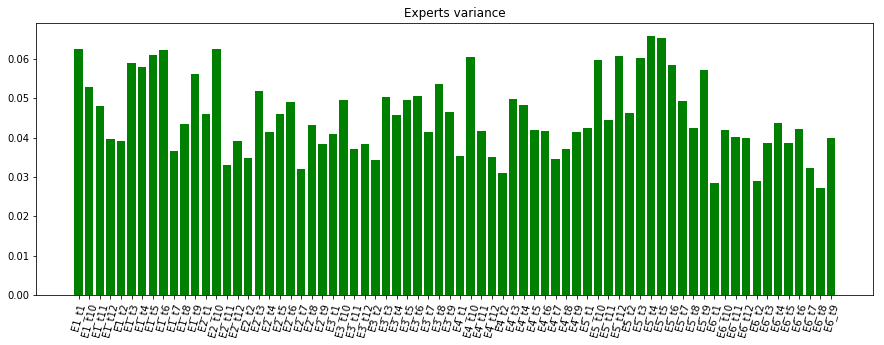

In [34]:
plt.figure(figsize=(15,5))
plt.bar(list(var_data.keys())[0:72],list(var_data.values())[0:72] , color='g')
plt.xticks(rotation=75)
plt.title("Experts variance")
# plt.bar(var_data_y.keys(),var_data_y.values(), color='g') 

Text(0.5,1,'Trainee Variance')

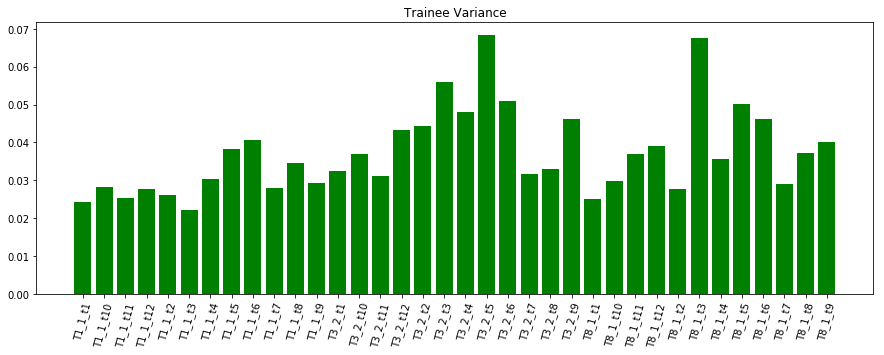

In [35]:
plt.figure(figsize=(15,5))
plt.bar(list(var_data.keys())[72:],list(var_data.values())[72:] , color='g')
plt.xticks(rotation=75)
plt.title("Trainee Variance")

# CURVATURE

In [36]:
np.array(list(curvature_data.values())[0:72]).mean() #Experts Curvature

7.652777777777778

In [37]:
np.array(list(curvature_data.values())[72:]).mean() #Trainees Curvature

14.86111111111111

Text(0.5,1,'Expert curvature')

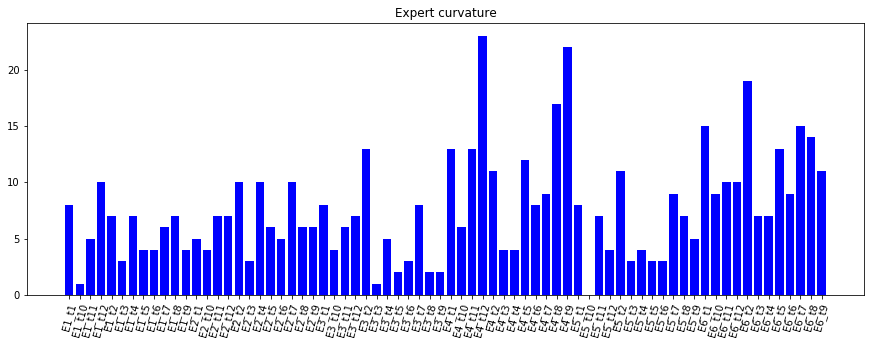

In [38]:
plt.figure(figsize=(15,5))
plt.bar(list(curvature_data.keys())[0:72],list(curvature_data.values())[0:72] , color='b')
plt.xticks(rotation=75)
plt.title("Expert curvature")

Text(0.5,1,'Trainee curvature')

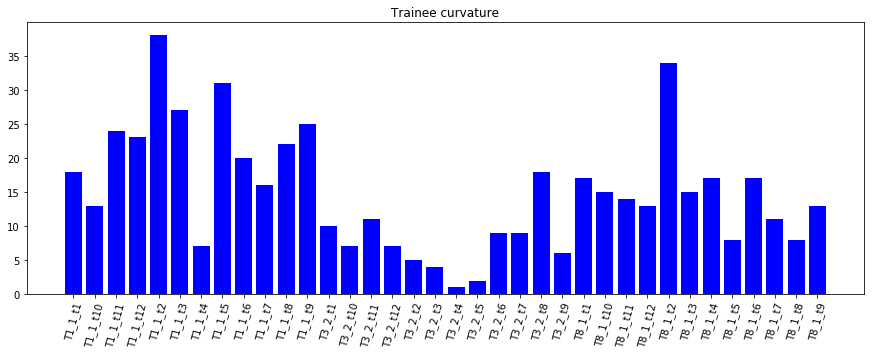

In [39]:
plt.figure(figsize=(15,5))
plt.bar(list(curvature_data.keys())[72:],list(curvature_data.values())[72:] , color='b')
plt.xticks(rotation=75)
plt.title("Trainee curvature")

# Arc Length

Text(0.5,1,'Experts Arc Length')

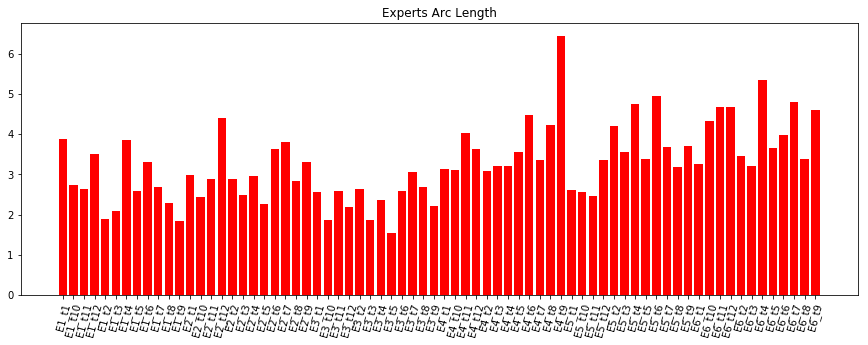

In [40]:
plt.figure(figsize=(15,5))
plt.bar(list(arc_length_data.keys())[0:72],list(arc_length_data.values())[0:72] , color='r')
plt.xticks(rotation=75)
plt.title("Experts Arc Length")


Text(0.5,1,'Trainee Arc Length')

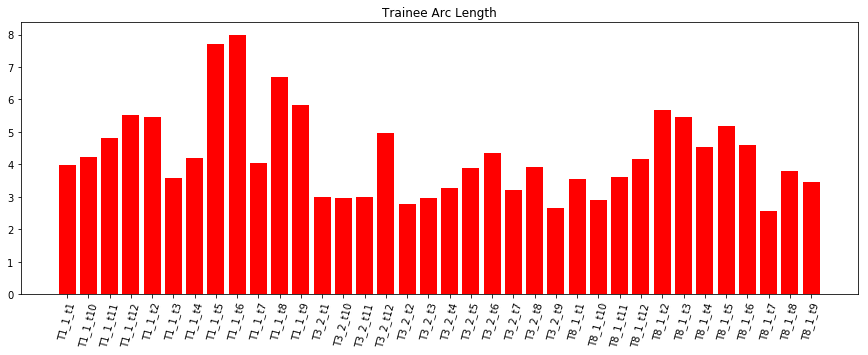

In [41]:
plt.figure(figsize=(15,5))
plt.bar(list(arc_length_data.keys())[72:],list(arc_length_data.values())[72:] , color='r')
plt.xticks(rotation=75)
plt.title("Trainee Arc Length")


In [42]:
np.array(list(arc_length_data.values())[0:72]).mean() #Experts arc_length_data

3.274274615834788

In [43]:
np.array(list(arc_length_data.values())[72:]).mean() #Trainees arc_length_data

4.292852383805169

In [44]:
labels_gt = pd.read_csv('./data/expert_scores_trainee_scores.csv',  index_col="Video")

In [45]:
data_gt = pd.read_csv("./data/features.csv", index_col="VIDEO")

In [105]:
data_gt

,NUMBER_OF_HITS,HIT_INTENSITY,NUMBER_OF_TUG,TOTAL_FRAMES_IN_TUG,NUMBER_OF_JERK_FRAMES,TIME,NUMBER_OF_RINGDROP,VARIANCE,ARC_LENGTH,CURVATURE_MAX_COUNT
VIDEO,,,,,,,,,,
E1_t10,2,0,2,23,0,11.96,0,0.052821,2.750350,1
E1_t11,2,0,1,19,0,12.96,0,0.048060,2.638573,5
E1_t12,2,0,3,26,0,20.96,0,0.039564,3.522528,10
E1_t1,2,1,1,9,6,19.96,0,0.062609,3.874484,8
E1_t2,0,0,1,3,0,10.68,1,0.039239,1.886396,7
E1_t3,0,0,2,19,3,8.96,0,0.058930,2.086997,3
E1_t4,1,0,1,17,5,16.84,0,0.057878,3.858408,7
E1_t5,1,0,1,15,3,11.00,0,0.061005,2.589191,4
E1_t6,2,0,1,16,0,12.96,0,0.062297,3.308289,4


In [124]:
labels_gt

,Hand-eye Coordination,Instrument-Tissue Manipulation,Dexterity,Flow of procedure,Effectualness,Overall
Video,,,,,,
E1_t1,3,3,3,3,4,15
E1_t2,3,3,3,2,1,8
E1_t3,4,3,4,4,4,18
E1_t4,3,2,4,4,4,16
E1_t5,3,3,4,4,4,17
E1_t6,3,3,4,4,4,17
E1_t7,4,4,4,4,4,20
E1_t8,3,3,4,4,4,17
E1_t9,4,4,4,4,4,20


Text(0.5,1,'Experts NUMBER_OF_HITS')

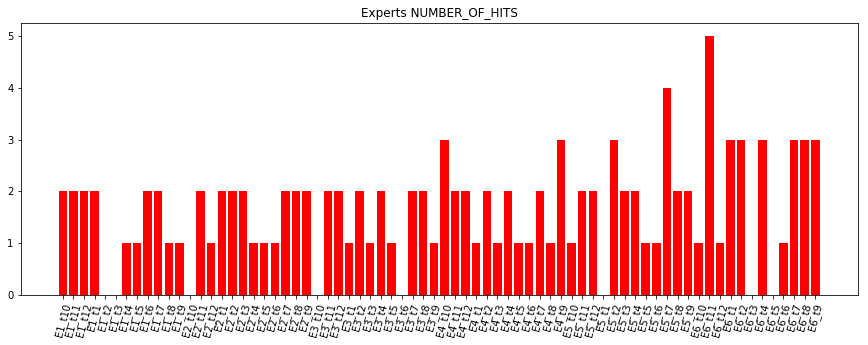

In [113]:
plt.figure(figsize=(15,5))
plt.bar(list(data_gt.index)[0:72],list(data_gt["NUMBER_OF_HITS"].values.ravel())[0:72] , color='r')
plt.xticks(rotation=75)
plt.title("Experts NUMBER_OF_HITS")


Text(0.5,1,'Trainee NUMBER_OF_HITS')

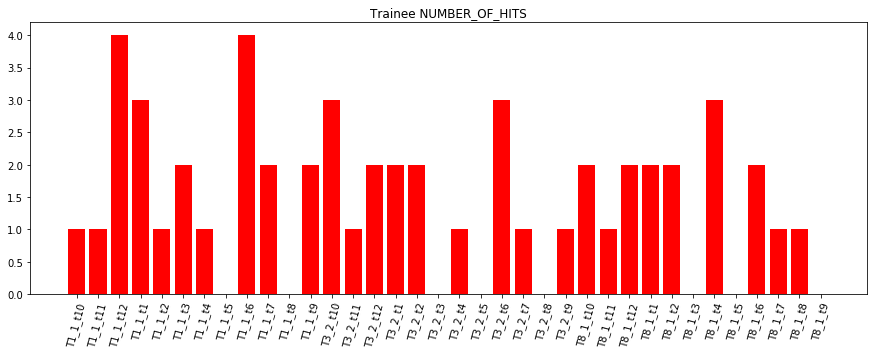

In [115]:
plt.figure(figsize=(15,5))
plt.bar(list(data_gt.index)[72:],list(data_gt["NUMBER_OF_HITS"].values.ravel())[72:] , color='r')
plt.xticks(rotation=75)
plt.title("Trainee NUMBER_OF_HITS")


In [117]:
print(np.array(list(data_gt["NUMBER_OF_HITS"].values.ravel())[:72]).mean()) #Expert number of hits

1.6527777777777777


In [116]:
print(np.array(list(data_gt["NUMBER_OF_HITS"].values.ravel())[72:]).mean()) #Trainee number of hits

1.4722222222222223


Text(0.5,1,'Experts HIT_INTENSITY')

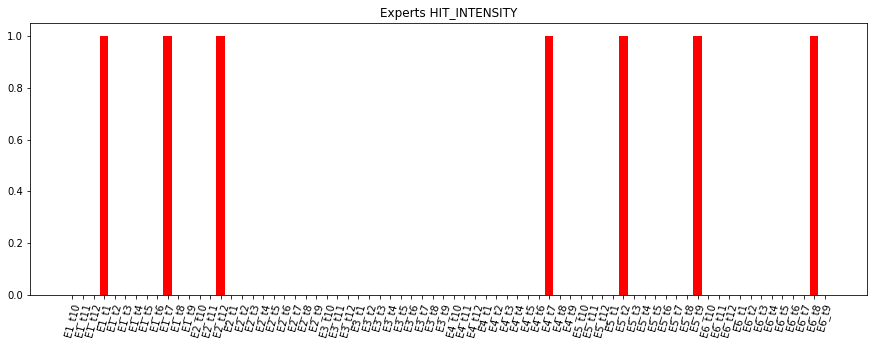

In [119]:
plt.figure(figsize=(15,5))
plt.bar(list(data_gt.index)[0:72],list(data_gt["HIT_INTENSITY"].values.ravel())[0:72] , color='r')
plt.xticks(rotation=75)
plt.title("Experts HIT_INTENSITY")


In [130]:
data_gt.loc["E4_t7"]

NUMBER_OF_HITS            2.000000
HIT_INTENSITY             1.000000
NUMBER_OF_TUG             0.000000
TOTAL_FRAMES_IN_TUG       0.000000
NUMBER_OF_JERK_FRAMES     2.000000
TIME                     23.800000
NUMBER_OF_RINGDROP        0.000000
VARIANCE                  0.034456
ARC_LENGTH                3.367377
CURVATURE_MAX_COUNT       9.000000
Name: E4_t7, dtype: float64

In [131]:
labels_gt.loc["E4_t7"]

Hand-eye Coordination              4
Instrument-Tissue Manipulation     4
Dexterity                          3
Flow of procedure                  4
Effectualness                      4
Overall                           19
Name: E4_t7, dtype: int64

Text(0.5,1,'Trainee HIT_INTENSITY')

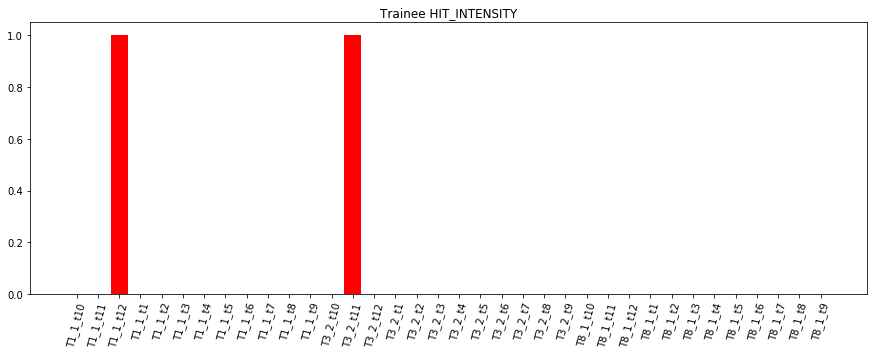

In [120]:
plt.figure(figsize=(15,5))
plt.bar(list(data_gt.index)[72:],list(data_gt["HIT_INTENSITY"].values.ravel())[72:] , color='r')
plt.xticks(rotation=75)
plt.title("Trainee HIT_INTENSITY")


In [122]:
print(np.array(list(data_gt["HIT_INTENSITY"].values.ravel())[:72]).mean()) #Expert number of hits

0.09722222222222222


In [ ]:
labels_gt[]

In [121]:
print(np.array(list(data_gt["HIT_INTENSITY"].values.ravel())[72:]).mean()) #Trainee number of hits

0.05555555555555555


Text(0.5,1,'Experts TIME')

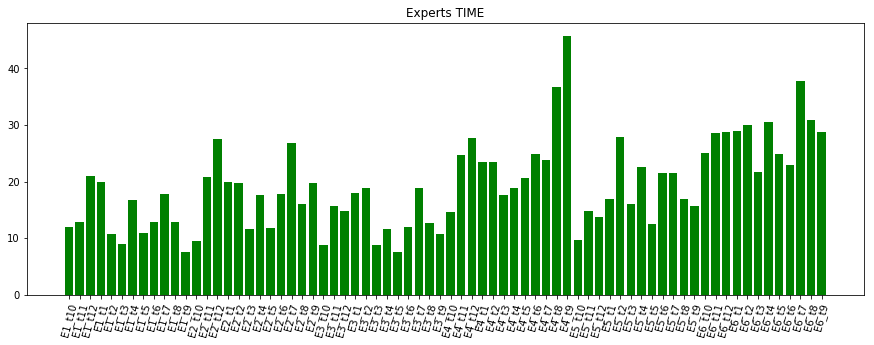

In [138]:
plt.figure(figsize=(15,5))
plt.bar(list(data_gt.index)[0:72],list(data_gt["TIME"].values.ravel())[0:72] , color='g')
plt.xticks(rotation=75)
plt.title("Experts TIME")


Text(0.5,1,'Trainee TIME')

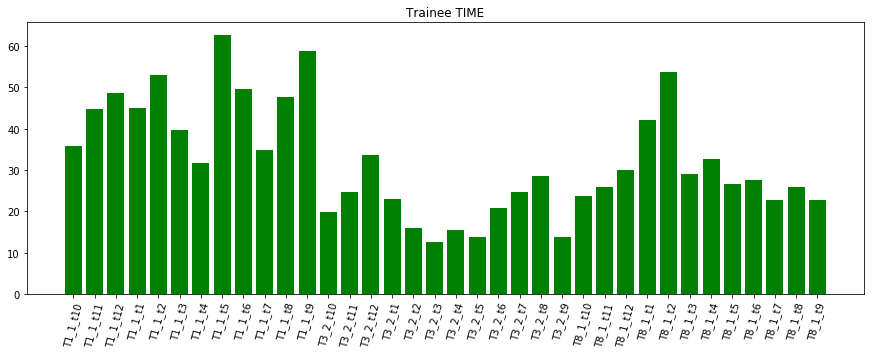

In [136]:
plt.figure(figsize=(15,5))
plt.bar(list(data_gt.index)[72:],list(data_gt["TIME"].values.ravel())[72:] , color='g')
plt.xticks(rotation=75)
plt.title("Trainee TIME")


In [137]:
print(np.array(list(data_gt["TIME"].values.ravel())[:72]).mean()) #Expert number of hits

19.358888888888888


In [133]:
print(np.array(list(data_gt["TIME"].values.ravel())[72:]).mean()) #Trainee number of hits

32.27111111111112


In [139]:
data_gt.columns

Index(['NUMBER_OF_HITS', 'HIT_INTENSITY', 'NUMBER_OF_TUG',
       'TOTAL_FRAMES_IN_TUG', 'NUMBER_OF_JERK_FRAMES', 'TIME',
       'NUMBER_OF_RINGDROP', 'VARIANCE', 'ARC_LENGTH', 'CURVATURE_MAX_COUNT'],
      dtype='object')

Text(0.5,1,'Experts NUMBER_OF_TUG')

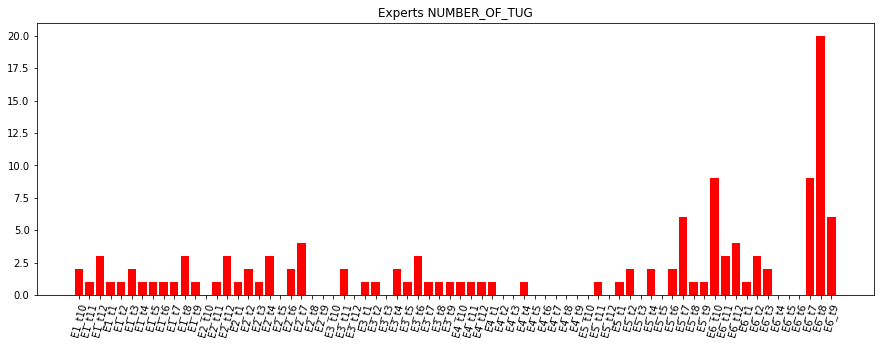

In [140]:
plt.figure(figsize=(15,5))
plt.bar(list(data_gt.index)[0:72],list(data_gt["NUMBER_OF_TUG"].values.ravel())[0:72] , color='r')
plt.xticks(rotation=75)
plt.title("Experts NUMBER_OF_TUG")


Text(0.5,1,'Trainee NUMBER_OF_TUG')

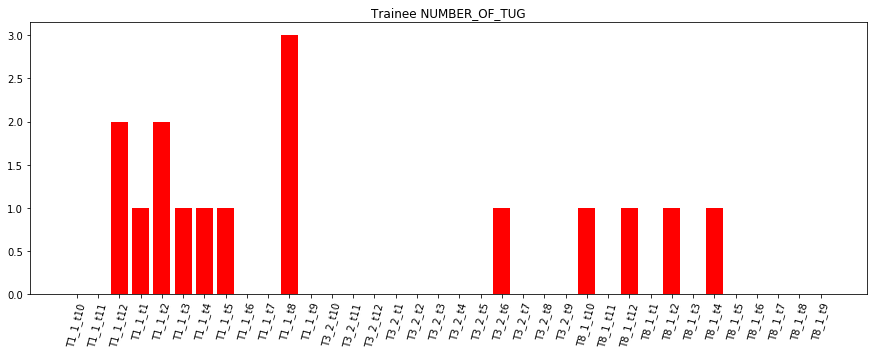

In [141]:
plt.figure(figsize=(15,5))
plt.bar(list(data_gt.index)[72:],list(data_gt["NUMBER_OF_TUG"].values.ravel())[72:] , color='r')
plt.xticks(rotation=75)
plt.title("Trainee NUMBER_OF_TUG")


In [143]:
print(np.array(list(data_gt["NUMBER_OF_TUG"].values.ravel())[:72]).mean()) #Expert number of hits

1.75


In [142]:
print(np.array(list(data_gt["NUMBER_OF_TUG"].values.ravel())[72:]).mean()) #Trainee number of hits

0.4444444444444444


Text(0.5,1,'Experts NUMBER_OF_HITS')

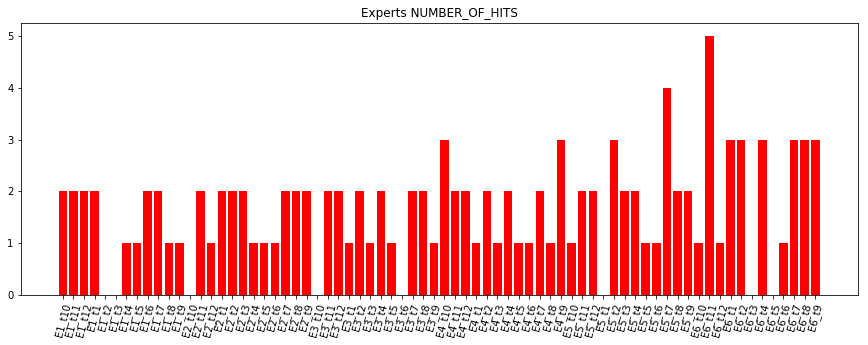

In [113]:
plt.figure(figsize=(15,5))
plt.bar(list(data_gt.index)[0:72],list(data_gt["NUMBER_OF_HITS"].values.ravel())[0:72] , color='r')
plt.xticks(rotation=75)
plt.title("Experts NUMBER_OF_HITS")


Text(0.5,1,'Trainee NUMBER_OF_HITS')

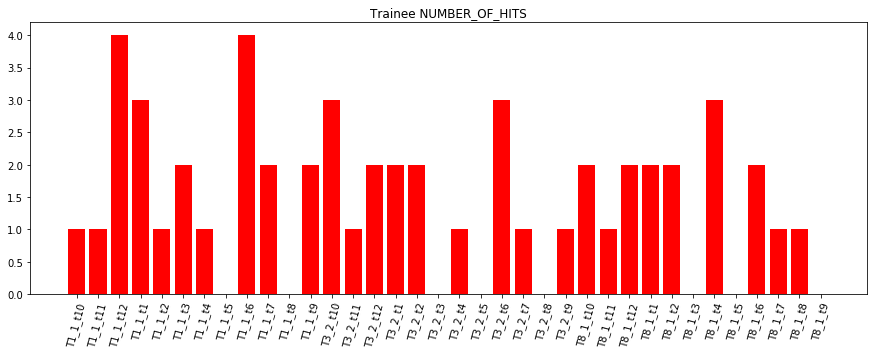

In [115]:
plt.figure(figsize=(15,5))
plt.bar(list(data_gt.index)[72:],list(data_gt["NUMBER_OF_HITS"].values.ravel())[72:] , color='r')
plt.xticks(rotation=75)
plt.title("Trainee NUMBER_OF_HITS")


In [117]:
print(np.array(list(data_gt["NUMBER_OF_HITS"].values.ravel())[:72]).mean()) #Expert number of hits

1.6527777777777777


In [116]:
print(np.array(list(data_gt["NUMBER_OF_HITS"].values.ravel())[72:]).mean()) #Trainee number of hits

1.4722222222222223


In [56]:
# len(list(zip(var_data_y.keys(),var_data_y.values())))

In [57]:
# feature_dict

In [58]:
data_gt = pd.DataFrame(feature_dict)
data_gt = data_gt.transpose()
data_gt.columns = ["NUMBER_OF_HITS", "HIT_INTENSITY", "NUMBER_OF_TUG", "TOTAL_FRAMES_IN_TUG", "NUMBER_OF_JERK", "TIME", "NUMBER_OF_RINGDROP", "VARIANCE", "ARC_LENGTH", "CURVATURE_MAX_COUNT"]

In [59]:
data_gt

,NUMBER_OF_HITS,HIT_INTENSITY,NUMBER_OF_TUG,TOTAL_FRAMES_IN_TUG,NUMBER_OF_JERK,TIME,NUMBER_OF_RINGDROP,VARIANCE,ARC_LENGTH,CURVATURE_MAX_COUNT
E1_t10,2.0,0.0,2.0,23.0,0.0,11.96,0.0,0.055537,2.828808,4.0
E1_t11,2.0,0.0,1.0,19.0,0.0,12.96,0.0,0.052004,2.890275,2.0
E1_t12,2.0,0.0,3.0,26.0,0.0,20.96,0.0,0.042266,3.817860,7.0
E1_t1,2.0,1.0,1.0,9.0,6.0,19.96,0.0,0.065039,4.125250,6.0
E1_t2,0.0,0.0,1.0,3.0,0.0,10.68,1.0,0.041579,2.041423,6.0
E1_t3,0.0,0.0,2.0,19.0,3.0,8.96,0.0,0.062049,2.291063,0.0
E1_t4,1.0,0.0,1.0,17.0,5.0,16.84,0.0,0.059762,3.938559,10.0
E1_t5,1.0,0.0,1.0,15.0,3.0,11.00,0.0,0.065748,2.850051,4.0
E1_t6,2.0,0.0,1.0,16.0,0.0,12.96,0.0,0.067365,3.467515,2.0
E1_t7,2.0,1.0,1.0,31.0,0.0,17.76,0.0,0.038523,2.792139,3.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c87008208>,
      dtype=object)

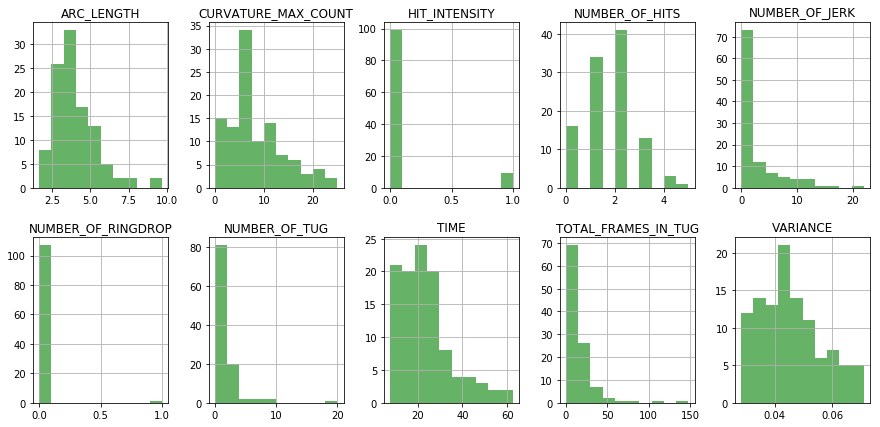

In [60]:
data_gt.hist(color='g', alpha=0.6, bins=10, layout=(2,5), figsize=(15,7))

In [86]:
normalized_data_gt=(data_gt-data_gt.min())/(data_gt.max()-data_gt.min())
#column wise normalize

In [87]:
normalized_data_gt

,NUMBER_OF_HITS,HIT_INTENSITY,NUMBER_OF_TUG,TOTAL_FRAMES_IN_TUG,NUMBER_OF_JERK,TIME,NUMBER_OF_RINGDROP,VARIANCE,ARC_LENGTH,CURVATURE_MAX_COUNT
E1_t10,0.4,0.0,0.10,0.155405,0.000000,0.078603,0.0,0.171322,0.082744,0.000000
E1_t11,0.4,0.0,0.05,0.128378,0.000000,0.096798,0.0,0.125858,0.067082,0.000000
E1_t12,0.4,0.0,0.15,0.175676,0.000000,0.242358,0.0,0.031771,0.054337,0.428571
E1_t1,0.4,1.0,0.05,0.060811,0.272727,0.224163,0.0,0.211102,0.155295,0.142857
E1_t2,0.0,0.0,0.05,0.020270,0.000000,0.055313,1.0,0.054714,0.000000,0.285714
E1_t3,0.0,0.0,0.10,0.128378,0.136364,0.024017,0.0,0.255936,0.072082,0.000000
E1_t4,0.2,0.0,0.05,0.114865,0.227273,0.167394,0.0,0.093713,0.073486,0.142857
E1_t5,0.2,0.0,0.05,0.101351,0.136364,0.061135,0.0,0.265331,0.100320,0.142857
E1_t6,0.4,0.0,0.05,0.108108,0.000000,0.096798,0.0,0.090861,0.041185,0.000000
E1_t7,0.4,1.0,0.05,0.209459,0.000000,0.184134,0.0,0.028122,0.022445,0.428571


In [88]:
normalized_data_gt.to_csv("./data/scaled_features.csv")

In [89]:
from sklearn import preprocessing

# Get column names first
names = data_gt.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(data_gt)
scaled_df = pd.DataFrame(scaled_df, columns=names)

In [42]:
scaled_df

,NUMBER_OF_HITS,HIT_INTENSITY,NUMBER_OF_TUG,TOTAL_FRAMES_IN_TUG,NUMBER_OF_JERK,TIME,NUMBER_OF_RINGDROP,VARIANCE,ARC_LENGTH,CURVATURE_MAX_COUNT
0,0.396412,-0.301511,0.282509,0.419985,-0.645278,-1.007696,-0.096674,0.325795,-0.426553,-0.639346
1,0.396412,-0.301511,-0.129801,0.242109,-0.645278,-0.921590,-0.096674,-0.005599,-0.525207,-0.179017
2,0.396412,-0.301511,0.694818,0.553392,-0.645278,-0.232742,-0.096674,-0.713712,-0.663410,0.281312
3,0.396412,3.316625,-0.129801,-0.202581,0.842766,-0.318848,-0.096674,0.679125,0.277776,-0.639346
4,-1.549612,-0.301511,-0.129801,-0.469395,-0.645278,-1.117912,10.344080,-0.525501,-1.126890,0.741642
5,-1.549612,-0.301511,0.282509,0.242109,0.098744,-1.266015,-0.096674,1.069222,-0.494145,-1.099676
6,-0.576600,-0.301511,-0.129801,0.153171,0.594758,-0.587499,-0.096674,-0.179994,-0.442251,-1.099676
7,-0.576600,-0.301511,-0.129801,0.064233,0.098744,-1.090358,-0.096674,1.069095,-0.230291,-0.639346
8,0.396412,-0.301511,-0.129801,0.108702,-0.645278,-0.921590,-0.096674,-0.252984,-0.797330,-1.099676
9,0.396412,3.316625,-0.129801,0.775737,-0.645278,-0.508281,-0.096674,-0.757508,-0.947354,-0.639346


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4450d55400>,
      dtype=object)

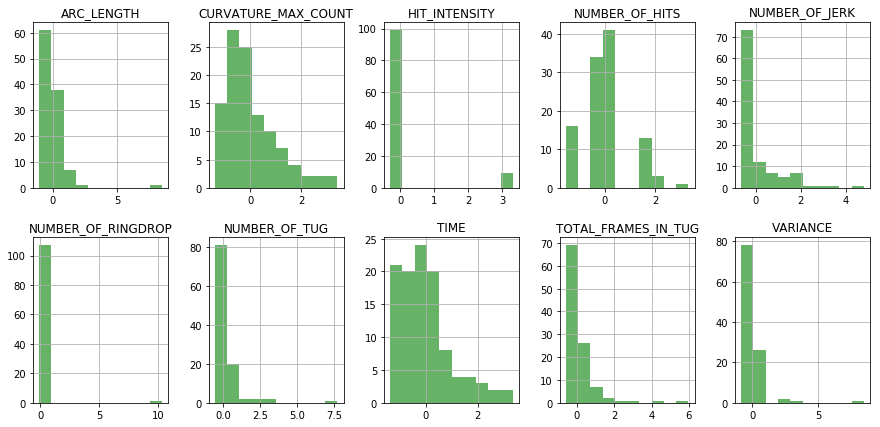

In [56]:
scaled_df.hist(color='g', alpha=0.6, bins=10, layout=(2,5), figsize=(15,7))

In [57]:
scaled_df.to_csv("./data/standard_scaled_features.csv")

In [58]:
df.set_index("Video")

,Hand-eye Coordination,Instrument-Tissue Manipulation,Dexterity,Flow of procedure,Effectualness,Overall
Video,,,,,,
E1_t1,3,3,3,3,4,15
E1_t2,3,3,3,2,1,8
E1_t3,4,3,4,4,4,18
E1_t4,3,2,4,4,4,16
E1_t5,3,3,4,4,4,17
E1_t6,3,3,4,4,4,17
E1_t7,4,4,4,4,4,20
E1_t8,3,3,4,4,4,17
E1_t9,4,4,4,4,4,20


In [48]:
JOINT = normalized_data_gt.join(df.set_index("Video"))

In [49]:
JOINT

,NUMBER_OF_HITS,HIT_INTENSITY,NUMBER_OF_TUG,TOTAL_FRAMES_IN_TUG,NUMBER_OF_JERK,TIME,NUMBER_OF_RINGDROP,VARIANCE,ARC_LENGTH,CURVATURE_MAX_COUNT,Hand-eye Coordination,Instrument-Tissue Manipulation,Dexterity,Flow of procedure,Effectualness,Overall
E1_t10,0.4,0.0,0.10,0.155405,0.000000,0.078603,0.0,0.111386,0.058445,0.026316,4,3,4,4,4,19
E1_t11,0.4,0.0,0.05,0.128378,0.000000,0.096798,0.0,0.094005,0.053088,0.131579,4,3,4,4,4,19
E1_t12,0.4,0.0,0.15,0.175676,0.000000,0.242358,0.0,0.062989,0.095453,0.263158,4,2,4,4,4,18
E1_t1,0.4,1.0,0.05,0.060811,0.272727,0.224163,0.0,0.147120,0.112322,0.210526,3,3,3,3,4,15
E1_t2,0.0,0.0,0.05,0.020270,0.000000,0.055313,1.0,0.061804,0.017037,0.184211,3,3,3,2,1,8
E1_t3,0.0,0.0,0.10,0.128378,0.136364,0.024017,0.0,0.133688,0.026652,0.078947,4,3,4,4,4,18
E1_t4,0.2,0.0,0.05,0.114865,0.227273,0.167394,0.0,0.129847,0.111551,0.184211,3,2,4,4,4,16
E1_t5,0.2,0.0,0.05,0.101351,0.136364,0.061135,0.0,0.141265,0.050721,0.105263,3,3,4,4,4,17
E1_t6,0.4,0.0,0.05,0.108108,0.000000,0.096798,0.0,0.145981,0.085186,0.105263,3,3,4,4,4,17
E1_t7,0.4,1.0,0.05,0.209459,0.000000,0.184134,0.0,0.052121,0.055169,0.157895,4,4,4,4,4,20


In [55]:
normalized_data_gt.columns

Index(['NUMBER_OF_HITS', 'HIT_INTENSITY', 'NUMBER_OF_TUG',
       'TOTAL_FRAMES_IN_TUG', 'NUMBER_OF_JERK', 'TIME', 'NUMBER_OF_RINGDROP',
       'VARIANCE', 'ARC_LENGTH', 'CURVATURE_MAX_COUNT'],
      dtype='object')

In [56]:
Y = JOINT["Overall"]

In [57]:
HE = JOINT[['NUMBER_OF_HITS', 'HIT_INTENSITY', 'NUMBER_OF_TUG',
       'TOTAL_FRAMES_IN_TUG', 'NUMBER_OF_JERK', 'TIME', 'NUMBER_OF_RINGDROP',
       'VARIANCE', 'ARC_LENGTH', 'CURVATURE_MAX_COUNT', 'Hand-eye Coordination']]
IT = JOINT[['NUMBER_OF_HITS', 'HIT_INTENSITY', 'NUMBER_OF_TUG',
       'TOTAL_FRAMES_IN_TUG', 'NUMBER_OF_JERK', 'TIME', 'NUMBER_OF_RINGDROP',
       'VARIANCE', 'ARC_LENGTH', 'CURVATURE_MAX_COUNT', 'Instrument-Tissue Manipulation']]
DT = JOINT[['NUMBER_OF_HITS', 'HIT_INTENSITY', 'NUMBER_OF_TUG',
       'TOTAL_FRAMES_IN_TUG', 'NUMBER_OF_JERK', 'TIME', 'NUMBER_OF_RINGDROP',
       'VARIANCE', 'ARC_LENGTH', 'CURVATURE_MAX_COUNT', 'Dexterity']]
FP = JOINT[['NUMBER_OF_HITS', 'HIT_INTENSITY', 'NUMBER_OF_TUG',
       'TOTAL_FRAMES_IN_TUG', 'NUMBER_OF_JERK', 'TIME', 'NUMBER_OF_RINGDROP',
       'VARIANCE', 'ARC_LENGTH', 'CURVATURE_MAX_COUNT', 'Flow of procedure']]

In [58]:
HE["Hand-eye Coordination"].value_counts()

4    44
3    38
2     6
1     5
Name: Hand-eye Coordination, dtype: int64

In [59]:
IT["Instrument-Tissue Manipulation"].value_counts()

3    50
4    28
2    12
1     3
Name: Instrument-Tissue Manipulation, dtype: int64

In [60]:
FP["Flow of procedure"].value_counts()

4    72
3    16
2     4
1     1
Name: Flow of procedure, dtype: int64

In [61]:
DT["Dexterity"].value_counts()

4    52
3    32
2     7
1     2
Name: Dexterity, dtype: int64

In [62]:
from sklearn.utils import resample
# Separate majority and minority classes

HE["Hand-eye Coordination"].value_counts()

A4 = HE[HE.loc[:, "Hand-eye Coordination"].values == 4]
A3 = HE[HE.loc[:, "Hand-eye Coordination"].values == 3]
A2 = HE[HE.loc[:, "Hand-eye Coordination"].values == 2]
A1  = HE[HE.loc[:, "Hand-eye Coordination"].values == 1]

#Get the length of majority
max_len = max(len(A4), len(A3), len(A2), len(A1))
print(max_len)
# Upsample minority class
A3_upsampled = resample(A3, 
                        replace=True,     # sample with replacement
                        n_samples=max_len,    # to match majority class
                        random_state=123) # reproducible results
A2_upsampled = resample(A2, 
                        replace=True,     # sample with replacement
                        n_samples=max_len,    # to match majority class
                        random_state=123) # reproducible results
A1_upsampled = resample(A1, 
                        replace=True,     # sample with replacement
                        n_samples=max_len,    # to match majority class
                        random_state=123) # reproducible results


# Combine majority class with upsampled minority class
HE_new = pd.concat([A4, A3_upsampled, A2_upsampled, A1_upsampled])
 
# Display new class counts
HE_new["Hand-eye Coordination"].value_counts()

44


4    44
3    44
2    44
1    44
Name: Hand-eye Coordination, dtype: int64

In [63]:
from sklearn.utils import resample
# Separate majority and minority classes

 
IT4 = IT[IT.loc[:, "Instrument-Tissue Manipulation"].values == 4]
IT3 = IT[IT.loc[:, "Instrument-Tissue Manipulation"].values == 3]
IT2 = IT[IT.loc[:, "Instrument-Tissue Manipulation"].values == 2]
IT1  = IT[IT.loc[:, "Instrument-Tissue Manipulation"].values == 1]
IT_sorted = pd.concat([IT4, IT3, IT2, IT1])
#Get the length of majority
arr = np.array([len(IT4), len(IT3), len(IT2), len(IT1)])
result = np.where(arr == np.amax(arr))
print(np.amax(arr))
print(result)
# Upsample minority class
IT4_upsampled = resample(IT4, 
                        replace=True,     # sample with replacement
                        n_samples=max_len,    # to match majority class
                        random_state=123) # reproducible results
IT2_upsampled = resample(IT2, 
                        replace=True,     # sample with replacement
                        n_samples=max_len,    # to match majority class
                        random_state=123) # reproducible results
IT1_upsampled = resample(IT1, 
                        replace=True,     # sample with replacement
                        n_samples=max_len,    # to match majority class
                        random_state=123) # reproducible results


# Combine majority class with upsampled minority class
IT_new = pd.concat([IT4_upsampled, IT3, IT2_upsampled, IT1_upsampled])
 
# Display new class counts
IT_new["Instrument-Tissue Manipulation"].value_counts()

50
(array([1]),)


3    50
4    44
2    44
1    44
Name: Instrument-Tissue Manipulation, dtype: int64

In [64]:
from sklearn.utils import resample
# Separate majority and minority classes

DT["Dexterity"].value_counts()

DT4 = DT[DT.loc[:, "Dexterity"].values == 4]
DT3 = DT[DT.loc[:, "Dexterity"].values == 3]
DT2 = DT[DT.loc[:, "Dexterity"].values == 2]
DT1  = DT[DT.loc[:, "Dexterity"].values == 1]

#Get the length of majority
max_len = max(len(DT4), len(DT3), len(DT2), len(DT1))
print(max_len)
# Upsample minority class
DT3_upsampled = resample(DT3, 
                        replace=True,     # sample with replacement
                        n_samples=max_len,    # to match majority class
                        random_state=123) # reproducible results
DT2_upsampled = resample(DT2, 
                        replace=True,     # sample with replacement
                        n_samples=max_len,    # to match majority class
                        random_state=123) # reproducible results
DT1_upsampled = resample(DT1, 
                        replace=True,     # sample with replacement
                        n_samples=max_len,    # to match majority class
                        random_state=123) # reproducible results


# Combine majority class with upsampled minority class
DT_new = pd.concat([DT4, DT3_upsampled, DT2_upsampled, DT1_upsampled])

# Display new class counts
DT_new["Dexterity"].value_counts()

52


4    52
3    52
2    52
1    52
Name: Dexterity, dtype: int64

In [65]:
from sklearn.utils import resample
# Separate majority and minority classes

FP["Flow of procedure"].value_counts()

FP4 = FP[FP.loc[:, "Flow of procedure"].values == 4]
FP3 = FP[FP.loc[:, "Flow of procedure"].values == 3]
FP2 = FP[FP.loc[:, "Flow of procedure"].values == 2]
FP1  = FP[FP.loc[:, "Flow of procedure"].values == 1]

#Get the length of majority
max_len = max(len(FP4), len(FP3), len(FP2), len(FP1))
print(max_len)
# Upsample minority class
FP3_upsampled = resample(FP3, 
                        replace=True,     # sample with replacement
                        n_samples=max_len,    # to match majority class
                        random_state=123) # reproducible results
FP2_upsampled = resample(FP2, 
                        replace=True,     # sample with replacement
                        n_samples=max_len,    # to match majority class
                        random_state=123) # reproducible results
FP1_upsampled = resample(FP1, 
                        replace=True,     # sample with replacement
                        n_samples=max_len,    # to match majority class
                        random_state=123) # reproducible results


# Combine majority class with upsampled minority class
FP_new = pd.concat([FP4, FP3_upsampled, FP2_upsampled, FP1_upsampled])
 
# Display new class counts
FP_new["Flow of procedure"].value_counts()

72


4    72
3    72
2    72
1    72
Name: Flow of procedure, dtype: int64

In [66]:
X = HE_new[['NUMBER_OF_HITS', 'HIT_INTENSITY', 'NUMBER_OF_TUG',
       'TOTAL_FRAMES_IN_TUG', 'NUMBER_OF_JERK', 'TIME', 'NUMBER_OF_RINGDROP',
       'VARIANCE', 'ARC_LENGTH', 'CURVATURE_MAX_COUNT']]

In [67]:
X = HE[['NUMBER_OF_HITS', 'HIT_INTENSITY', 'NUMBER_OF_TUG',
       'TOTAL_FRAMES_IN_TUG', 'NUMBER_OF_JERK', 'TIME', 'NUMBER_OF_RINGDROP',
       'VARIANCE', 'ARC_LENGTH', 'CURVATURE_MAX_COUNT']]

In [68]:
X

,NUMBER_OF_HITS,HIT_INTENSITY,NUMBER_OF_TUG,TOTAL_FRAMES_IN_TUG,NUMBER_OF_JERK,TIME,NUMBER_OF_RINGDROP,VARIANCE,ARC_LENGTH,CURVATURE_MAX_COUNT
E1_t10,0.4,0.0,0.10,0.155405,0.000000,0.078603,0.0,0.340096,0.170420,0.026316
E1_t11,0.4,0.0,0.05,0.128378,0.000000,0.096798,0.0,0.275642,0.148542,0.131579
E1_t12,0.4,0.0,0.15,0.175676,0.000000,0.242358,0.0,0.184697,0.267084,0.263158
E1_t1,0.4,1.0,0.05,0.060811,0.272727,0.224163,0.0,0.261132,0.227164,0.236842
E1_t2,0.0,0.0,0.05,0.020270,0.000000,0.055313,1.0,0.181222,0.047672,0.184211
E1_t3,0.0,0.0,0.10,0.128378,0.136364,0.024017,0.0,0.392002,0.074573,0.078947
E1_t4,0.2,0.0,0.05,0.114865,0.227273,0.167394,0.0,0.380739,0.312127,0.184211
E1_t5,0.2,0.0,0.05,0.101351,0.136364,0.061135,0.0,0.414221,0.141920,0.105263
E1_t6,0.4,0.0,0.05,0.108108,0.000000,0.096798,0.0,0.434658,0.233527,0.105263
E1_t7,0.4,1.0,0.05,0.209459,0.000000,0.184134,0.0,0.152831,0.154366,0.157895


In [69]:
Y = HE_new["Hand-eye Coordination"]

In [70]:
Y

E1_t10     4
E1_t11     4
E1_t12     4
E1_t3      4
E1_t7      4
E1_t9      4
E2_t10     4
E2_t11     4
E2_t1      4
E2_t2      4
E2_t3      4
E2_t4      4
E2_t5      4
E2_t8      4
E2_t9      4
E3_t10     4
E3_t11     4
E3_t12     4
E3_t1      4
E3_t2      4
E3_t3      4
E3_t4      4
E3_t5      4
E3_t6      4
E3_t7      4
E3_t9      4
E4_t10     4
E4_t11     4
E4_t5      4
E4_t6      4
          ..
T1_1_t6    1
T1_1_t8    1
T1_1_t9    1
T1_1_t5    1
T1_1_t5    1
T1_1_t9    1
T1_1_t6    1
T1_1_t8    1
T1_1_t7    1
T1_1_t9    1
T1_1_t7    1
T1_1_t9    1
T1_1_t5    1
T1_1_t5    1
T1_1_t6    1
T1_1_t8    1
T1_1_t9    1
T1_1_t9    1
T1_1_t9    1
T1_1_t6    1
T1_1_t8    1
T1_1_t7    1
T1_1_t6    1
T1_1_t9    1
T1_1_t5    1
T1_1_t8    1
T1_1_t7    1
T1_1_t5    1
T1_1_t8    1
T1_1_t7    1
Name: Hand-eye Coordination, Length: 176, dtype: int64

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=40) #70 | 30


ValueError: Found input variables with inconsistent numbers of samples: [93, 176]

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(3) # EXPLAINATION ?
X_train_vis = pca.fit_transform(X_train)
X_test_vis = pca.transform(X_test)

In [ ]:
print(pca.explained_variance_) # EXPLAiNATION ?

In [ ]:
X_train_vis #3 COMPONENT

NameError: name 'X_train_vis' is not defined

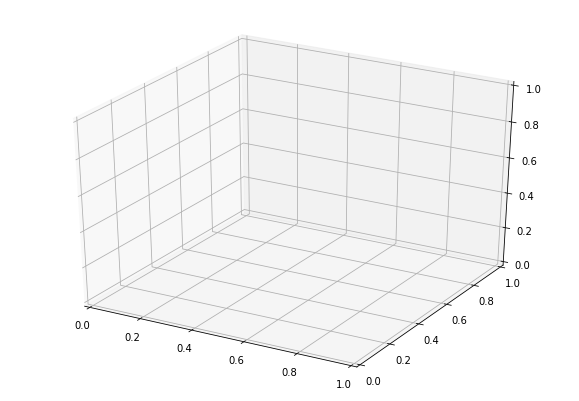

In [72]:
"""################### PCA 3d PLOT ##############################################"""

from mpl_toolkits import mplot3d 

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

fig = plt.figure(figsize = (10, 7)) 
ax = plt.axes(projection ="3d") 

    # plot data
ax.scatter3D(X_train_vis[:, 0], X_train_vis[:, 1],X_train_vis[:, 2], alpha=0.8)
# for length, vector in zip(pca.explained_variance_, pca.components_):
#     v = vector * 3 * np.sqrt(length)
#     #draw_vector(pca.mean_, pca.mean_ + v)
# plt.axis('equal');


In [ ]:
################################# OPTION 0 : UNSUPERVISED CLUSTERING ###################################

In [73]:
from sklearn.cluster import KMeans

In [74]:
estimator = KMeans(n_clusters=5)

In [75]:
estimator.fit(X_train_vis)

NameError: name 'X_train_vis' is not defined

In [76]:
labels = estimator.labels_
fig = plt.figure(figsize = (10, 7)) 
ax = plt.axes(projection ="3d") 

ax.scatter(X_train_vis[:, 0], X_train_vis[:, 1], X_train_vis[:, 2],
           c=labels.astype(np.float), edgecolor='k')

AttributeError: 'KMeans' object has no attribute 'labels_'

In [77]:
##################  OPTION 1 : SUPERVISED FOR OVERALL SCORE WITH BINNING OF LABELS      ################

In [78]:
#Random Forest Test
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=5, random_state=40)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

NameError: name 'X_train' is not defined

In [79]:
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.svm import SVC, SVR
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor , AdaBoostClassifier, AdaBoostRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

from sklearn.metrics import label_ranking_loss 

from sklearn.model_selection import GridSearchCV
import random
from scipy.stats import pearsonr

from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict

In [80]:
##### Classifier#######

In [81]:
k_folds = 3
gt_y_test = y_test.values.ravel()

#K-nearest classifier
# classifiers = KNeighborsClassifier()
# parameters = {"n_neighbors":[3,4,5], "algorithm" :["auto", "ball_tree", "kd_tree", "brute"]}
# clf = GridSearchCV(classifiers, parameters, scoring="accuracy",cv=k_folds)#make_scorer(label_ranking_loss)
# clf.fit(X_train, y_train.values.ravel())
# y_pred = clf.predict(X_test) #y_pred
#                     scores = cross_val_score(clf,X_train, y_train, cv=k_folds)

#MLP Classifier

#clf = MLPClassifier(solver='lbfgs', alpha=0.9,hidden_layer_sizes=(15, ), random_state=0)
#clf = MLPClassifier(random_state=0, max_iter=2000);
#clf.fit(X_train, y_train.values.ravel())
#y_pred = clf.predict_proba(X_test)
#y_pred = clf.predict(X_test)

#Random_Forest Classifier
clf = RandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


print(classification_report(gt_y_test,y_pred))

res = {}            
#res["estimator_type"] = model.__class__.__name__
res["accuracy_test"] = accuracy_score(gt_y_test, y_pred)
#res [" Score-MLP"] = clf.score(X_test, y_test)
#target_names = ["bad","fair","good","excellent"]
#test = cross_val_predict(clf.best_estimator_, X, Y.values.ravel(), cv=10)
r = pearsonr(y_pred, gt_y_test)
res["correlation coefficient"] = r[0]
#r = pearsonr(test, Y.values.ravel())
#res["correlation coefficient"] = r[0]
#res["accuracy_cross_val"] = clf.best_score_
#res["estimator"] = clf.best_estimator_
#res["parameter_search_dict"] = clf.best_params_
                    

NameError: name 'y_test' is not defined

In [82]:
res

NameError: name 'res' is not defined

In [83]:
#For classifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred) 
print(cm)
print('Accuracy' ,accuracy_score(y_test, y_pred))

NameError: name 'y_test' is not defined

In [84]:
################Regressor############

In [85]:
k_folds = 3
gt_y_test = y_test.values.ravel()
#regressors = KNeighborsRegressor(5)   
#parameters = {"n_neighbors":[3,4,5], "algorithm" :["auto", "ball_tree", "kd_tree", "brute"]}
regressors = RandomForestRegressor()
parameters = {"max_depth":[4,5,6,7,8], "n_estimators":[10,20], "max_features":[1,2,5]}
clf = GridSearchCV(regressors, parameters,scoring=make_scorer(mean_squared_error), cv=k_folds)
clf.fit(X_train, y_train.values.ravel())

#                     scores = cross_val_score(clf,X_train, y_train, cv=k_folds)
res = {}
y_pred = clf.predict(X_test) #y_pred

y_pred = y_pred.ravel()
#y_pred_round = y_pred
y_pred_round = [int(round(x)) for x in y_pred]
res = {}
mse_r2 = r2_score(gt_y_test, y_pred_round)
res["MSE_r2"] = mse_r2
res["accuracy_test"] = accuracy_score(gt_y_test, y_pred_round)
#test = [round(x) for x in test] #rounding to nearest integer
mse = mean_squared_error(y_pred_round,gt_y_test) #ypred vs gt y for test data
                    
test = cross_val_predict(clf.best_estimator_, X, Y.values.ravel(), cv=10)


r = pearsonr(test, Y.values.ravel())
res["correlation coeff."] = r[0]
#res["estimator_type"]= model.__class__.__name__
res["mse_test"] = mse
res["mse_cross_val"] = clf.best_score_
res["estimator"] = clf.best_estimator_
res["parameter_search_dict"] = clf.best_params_

NameError: name 'y_test' is not defined

In [494]:
res

{'MSE_r2': 0.919939577039275,
 'accuracy_test': 0.9056603773584906,
 'correlation coeff.': 0.9263204805779144,
 'mse_test': 0.09433962264150944,
 'mse_cross_val': 0.2512333312401935,
 'estimator': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=5, max_features=2, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False),
 'parameter_search_dict': {'max_depth': 5,
  'max_features': 2,
  'n_estimators': 10}}

In [495]:
#For regressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred_round) 
print(cm)
print('Accuracy' ,accuracy_score(y_test, y_pred_round))

[[13  0  0  0]
 [ 0 19  0  0]
 [ 0  0  9  0]
 [ 0  0  5  7]]
Accuracy 0.9056603773584906


[[13  0  0  0]
 [ 0 19  0  0]
 [ 0  1  4  4]
 [ 0  3  4  5]]
Accuracy 0.7735849056603774


In [332]:
test

array([3.53753864, 3.52535899, 3.57877345, 3.372905  , 3.38137268,
       3.33313673, 3.41091776, 3.47932724, 3.55685452, 3.56340246,
       3.49666601, 3.61723403, 3.53666819, 3.47932724, 3.44359023,
       3.56340246, 3.5498052 , 3.51737072, 3.48962198, 3.56376358,
       3.47932724, 3.35106083, 3.69350618, 3.54982196, 3.42724963,
       3.55052811, 3.61657436, 3.81282468, 3.65618475, 3.65694232,
       3.48897163, 3.55618475, 3.45122933, 3.29106083, 3.3324894 ,
       3.2487473 , 3.2487473 , 3.65163847, 3.30957793, 3.4251632 ,
       3.20495016, 3.29135367, 3.29456468, 3.16123914, 2.83660099,
       3.6050876 , 2.55517013, 3.47653135, 3.3085747 , 2.44642857,
       3.72991005, 3.40497514, 3.19050993, 3.17115039, 3.19050993,
       3.81096252, 3.39640131, 3.81096252, 3.14890842, 3.19154457,
       2.52018759, 2.45503342, 3.41059383, 2.0702381 , 2.4661306 ,
       3.6881002 , 3.70779428, 3.40244419, 3.44365   , 3.19049554,
       2.7330111 , 3.70779428, 3.43263353, 3.70779428, 3.19049

In [281]:
y_test.ravel()

array([3, 4, 3, 4, 1, 1, 2, 2, 2, 3, 2, 3, 1, 4, 2, 2, 2, 4, 1, 4, 4, 4,
       3, 1, 2, 2, 4, 2, 2, 3, 4, 2, 1, 1, 4, 2, 2, 1, 3, 1, 2, 2, 2, 3,
       1, 4, 1, 3, 1, 1, 3, 1, 4, 3, 2, 3, 1, 4, 3, 3, 2, 3, 3],
      dtype=int64)

In [282]:
y_pred

array([3, 4, 3, 4, 1, 1, 2, 2, 2, 3, 2, 3, 1, 4, 2, 2, 2, 4, 1, 4, 3, 4,
       3, 1, 2, 2, 4, 2, 2, 3, 4, 2, 1, 1, 4, 2, 2, 1, 4, 1, 2, 2, 2, 3,
       1, 4, 1, 2, 1, 1, 3, 1, 4, 3, 2, 1, 1, 3, 3, 3, 2, 3, 3],
      dtype=int64)

In [67]:
#################### OPTION 2 #################################################################

In [68]:
print(__doc__)


# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score


h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

Regressors = [
    KNeighborsRegressor(3),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestRegressor(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

Y = np.digitize(np.array(Y),np.array([5.0, 10.0, 15.0, 20.0]))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=40) #70 | 30


# iterate over classifiers
for name, clf in zip(names, classifiers):
    try :
        scores = cross_val_score(clf, X_train, y_train, cv=10)
        

        print(np.mean(scores), clf)
    except:
        print(clf)
        

#     # Plot the decision boundary. For that, we will assign a color to each
#     # point in the mesh [x_min, x_max]x[y_min, y_max].
#     if hasattr(clf, "decision_function"):
#         Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
#     else:
#         Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

#     # Put the result into a color plot
#     Z = Z.reshape(xx.shape)
#     ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

#     # Plot the training points
#     ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
#                edgecolors='k')
#     # Plot the testing points
#     ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
#                edgecolors='k', alpha=0.6)

#     ax.set_xlim(xx.min(), xx.max())
#     ax.set_ylim(yy.min(), yy.max())
#     ax.set_xticks(())
#     ax.set_yticks(())
#     if ds_cnt == 0:
#         ax.set_title(name)
#     ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
#             size=15, horizontalalignment='right')
#     i += 1

# plt.tight_layout()
# plt.show()

################### PCA 3d PLOT ##############################################


NameError: name 'RandomForestRegressor' is not defined

In [ ]:
##############################################################################################################

In [115]:
double varX = 0; 

double varY = 0; 

double arcLength = 0; 

double curvatureMax = 0; 

int curvatureMaxCount = 0; 

vector<pair <double, double > > x; 

vector<pair <double, double > > dx; 

vector<pair <double, double > > ddx; 

vector<double> Curvature; 

 vector<pair <double, double > > data = result.grasping.trackingData[i].second; 

qDebug() << " grasping normalize enter\n"; 

util::normalize2D(data, x); 

qDebug() << " data size \n" << data.size(); 

qDebug() << " x normalized data \n" << x.size(); 

for(int i = 0; i < x.size(); i++) 

{ 

      qDebug() << "x[i] - " << x[i] << endl; 

} 

qDebug() << " grasping diff2d enter 1\n"; 

 util::diff2D(x, dx); 

qDebug() << "grasping diff2d enter 2\n"; 

util::diff2D(dx, ddx); 

qDebug() << " grasping var2d enter 1\n"; 

util::var2D(dx, &varX, &varY); 

qDebug() << "grasping curvature enter 1\n"; 

util::curvature(dx, ddx, Curvature); 

qDebug() << "grasping curvature max count enter\n"; 

 util::curvatureMaxnCount(Curvature, &curvatureMax, &curvatureMaxCount); 

qDebug() << "grasping arclength enter\n"; 

util::arclength(dx, &arcLength); 

result.grasping.curvatureMax.push_back(make_pair(result.grasping.trackingData[i].first, curvatureMax)); 

result.grasping.arcLength.push_back(make_pair(result.grasping.trackingData[i].first, arcLength)); 

result.grasping.curvatureMaxCount.push_back(make_pair(result.grasping.trackingData[i].first, curvatureMaxCount)); 



_________________________________________________________________________________ 

void util::normalize2D(const vector<pair <double, double > > &indata, vector<pair <double, double > > &outdata) 

{ 

    double meanX = 0; double meanY = 0; 

    double maxX = 0; double maxY = 0; 

    mean2D(indata, &meanX, &meanY); 

    outdata.clear(); 

    if(indata.size()) 

    { 

        for (int i = 0; i < indata.size(); ++i) 

        { 

            outdata.push_back(make_pair(indata[i].first - meanX, indata[i].second - meanY)); 

        } 

        max2D(outdata, &maxX, &maxY); 

        for (int i = 0; i < outdata.size(); ++i) 

        { 

            if(maxX != 0 && maxY != 0) 

            { 

                outdata[i].first = (outdata[i].first) / maxX; 

                outdata[i].second = (outdata[i].second) / maxY; 

            } 

        } 

    } 

} 

 _________________________________________________________________________________ 

void util::diff2D(const vector<pair <double, double > > &indata, vector<pair <double, double > > &outdata) 

{ 

    outdata.clear(); 

    int sz = ((int)indata.size())-1; 

    if( sz > 0) 

    { 

        for (int i = 0; i < sz ; ++i) 

        { 

            outdata.push_back(make_pair(indata[i + 1].first - indata[i].first, indata[i + 1].second - indata[i].second)); 

        } 

    } 

} 

 _______________________________________________________________________________ 

void util::var2D(const vector<pair <double, double > > &indata, double *varX, double *varY) 

{ 

    int sz = ((int)indata.size()) - 1; 

    if( sz > 0) 

    { 

        double meanX = 0; double meanY = 0; 

        double sumX = 0; double sumY = 0; 

        mean2D(indata, &meanX, &meanY); 

        for (int i = 0; i < sz ; ++i) 

        { 

            sumX += (indata[i].first - meanX) * (indata[i].first - meanX); 

            sumY += (indata[i].second - meanY) * (indata[i].second - meanY); 

        } 

        sumX /= indata.size() - 1; 

        sumY /= indata.size() - 1; 

    } 

} 

_________________________________________________________________________________ 

void util::curvature(const vector<pair <double, double > > &dx, 

    const vector<pair <double, double > > &ddx, 

    vector<double> &curvature) 

{ 

    curvature.clear(); 

    if(ddx.size()) 

    { 

        for (int i = 0; i < ddx.size(); ++i) 

        { 

            double dd = pow(dx[i].first * dx[i].first + dx[i].second * dx[i].second, 1.5); 

            if(dd != 0) 

            { 

                curvature.push_back(abs((dx[i].first * ddx[i].second) - (dx[i].second * ddx[i].first)) / dd); 

            } 

        } 

    } 

} 

_________________________________________________________________________________  

void util::arclength(const vector<pair <double, double > > &dx, double *arcLength) 

{ 

    if(dx.size()) 

    { 

        *arcLength = 0; 

        for (int i = 0; i < dx.size(); ++i) 

        { 

            *arcLength += pow(dx[i].first * dx[i].first + dx[i].second * dx[i].second, 0.5); 

        } 

    } 

} 

_____________________________________________________________________________ 

void util::curvatureMaxnCount(const vector<double > &curvature, double *curvatureMax, int*curvatureMaxCount) 

{ 

    if (curvature.size()) 

    { 

        *curvatureMax = curvature[0]; 

        for (int i = 1; i < curvature.size(); ++i) 

        { 

            if (abs(curvature[i]) > *curvatureMax) 

            { 

                *curvatureMax = abs(curvature[i]); 

            } 

            if (abs(curvature[i]) > 300) 

            { 

                *curvatureMaxCount++; 

            } 

        } 

    } 

    else 

    { 

        *curvatureMax = 0; 

        *curvatureMaxCount = 0; 

    } 

} 


SyntaxError: invalid syntax (<ipython-input-115-21fb722a18f5>, line 1)

In [61]:
tug = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,1,1,1,1,1,1]
tug_event=0
count=0; #000000111100000011000000111110000000
tug.append(0)
total = 0
for i in range(len(tug)):
    if tug[i]==1:
        count= count+1;

    if tug[i]==0 and count:
        total=total+count
        count = 0
        tug_event = tug_event +1

In [62]:
tug_event

4

In [63]:
total

18